# Universitat Oberta de Catalunya  
## Grado en Ingeniería Informática  
### Trabajo Final de Grado (TFG)

---

## Sistema de recomendaciones basado en técnicas de aprendizaje automático para ampliar la exploración de géneros musicales 
**Autor:** Marc Fernández Pereira  
**Bajo supervisión de:** Dra. María Moreno de Castro  
**Área:** Inteligencia Artificial  
**Semestre:** Otoño 2025  






---

## Índice

3. Fase de modelado

    - 3.1 Introducción
    - 3.2 Selección de las técnicas de modelado
    - 3.3 Generar un diseño de comprobación
    - 3.4 Diseño del pipeline de modelado
    - 3.5 Desarrollo de los modelos de *clustering*

### Imports, funciones y librerías


In [261]:
# Este import centraliza todas las librerías estándar, scikit-learn y funciones personalizadas
from imports import *

### Funciones


In [262]:
def generate_clusters_kmeans(k, df):
    """
    Ejecuta el algoritmo K-Means para un número de clústeres dado y devuelve 
    un DataFrame con las variables numéricas y las etiquetas asignadas.

    :param k: Número de clústeres (k) que se desea generar con el modelo K-Means.
    :param df: DataFrame de pandas que contiene las variables numéricas que se usarán para el clustering.

    :return
        - df_with_clusters (pandas.DataFrame): Subconjunto del DataFrame original que incluye 
          únicamente las columnas numéricas y una nueva columna con las etiquetas 
          de clúster asignadas.
        - cluster_label_col (str): Nombre de la columna generada que contiene las etiquetas 
          de los clústeres, con el formato 'clusters_kX', donde X corresponde al valor de k usado.
    """
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df)

    numeric_columns = df.select_dtypes(include='number').columns.tolist()
    if not numeric_columns:
        raise ValueError("El DataFrame debe contener columnas numéricas para generar clústeres.")

    df_with_clusters = df[numeric_columns].copy()
    cluster_label_col = f'clusters_k{k}'
    df_with_clusters[cluster_label_col] = labels

    return df_with_clusters, cluster_label_col


def compute_cluster_metrics(features, labels, silhouette_sample=10000):
    """
    Calcula Silhouette, Davies-Bouldin y Calinski-Harabasz para un agrupamiento dado.

    :param features: array o DataFrame con las características utilizadas en el clustering.
    :param labels: etiquetas asignadas a cada observación.
    :param silhouette_sample: tamaño máximo de muestra para la Silhouette (para datasets grandes).

    :return: diccionario con las tres métricas.
    """

    silhouette = silhouette_score(features, labels, sample_size=silhouette_sample, random_state=42)
    davies_bouldin = davies_bouldin_score(features, labels)
    calinski_harabasz = calinski_harabasz_score(features, labels)

    return {
        "Silhouette": round(silhouette, 2),
        "Davies_Bouldin": round(davies_bouldin, 2),
        "Calinski_Harabasz": round(calinski_harabasz, 2),
    }


def plot_clusters_kmeans(df_plot, cluster_col, pair_plots, sample_size=8000):
    """
    Genera una cuadrícula de dispersogramas bivariantes a partir de las salidas de K-Means.
    
    :param df_plot: DataFrame con las variables normalizadas y la columna de clúster asignada.
    cluster_col : str Nombre de la columna que contiene las etiquetas de clúster.
    pair_plots : list[tuple[str, str]] Lista de pares de variables que se desean visualizar.
    sample_size : int, opcional Número máximo de observaciones a representar. Por defecto 8000.
    """

    # Tomamos una muestra aleatoria del conjunto de datos para facilitar la visualización sin perder información característica.
    # Fijamos la semilla para garantizar la reproducibilidad de los resultados.
    sample_df = df_plot.sample(n=min(sample_size, len(df_plot)), random_state=42)

    # Distribuimos los gráficos en una cuadrícula de dos columnas de manera dinámica
    n_pairs = len(pair_plots)
    n_rows = (n_pairs + 1) // 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(18, 6 * n_rows))
    axs = axs.flatten()

    # Paleta fija con colores bien diferenciados (hasta 10 clústeres).
    palette_colors = [
        '#1f77b4',  # azul
        '#ff7f0e',  # naranja
        '#2ca02c',  # verde
        '#d62728',  # rojo
        '#9467bd',  # morado
        '#8c564b',  # marrón
        '#17becf',  # cian
        '#7f7f7f',  # gris
        '#bcbd22',  # oliva
        '#000000'   # negro
    ]

    clusters = sorted(sample_df[cluster_col].unique())
    palette = palette_colors[:len(clusters)]

    for i, (x_col, y_col) in enumerate(pair_plots):
        sns.scatterplot(data=sample_df, x=x_col, y=y_col, hue=cluster_col,hue_order=clusters, palette=palette, s=25,alpha=.7, ax=axs[i])
        axs[i].set_title(f'{x_col} vs {y_col}')
        axs[i].set_xlabel(x_col)
        axs[i].set_ylabel(y_col)

    # Eliminamos subplots sobrantes cuando hay un número impar de pares.
    for i in range(n_pairs, len(axs)):
        fig.delaxes(axs[i])

    fig.suptitle(f'Resultados de K-Means ({cluster_col})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()




# 3. Fase de modelado


## 3.1 Introducción

El objetivo de esta fase es abordar tanto el desarrollo como la evaluación del modelo mediante distintas técnicas de aprendizaje no supervisado. Después de llevar a cabo un análisis exploratorio del conjunto de datos y de preparar el dataset con el que se trabajará, se procede a integrar distintos algoritmos de *clustering* con el fin de identificar patrones de similitud entre canciones basados en sus características musicales. 

Para cada resultado obtenido con cada uno de los modelos se redactará una breve descripción que permitirá al lector comprender los resultados sin necesidad de dominar los fundamentos básicos de las técnicas del aprendizaje profundo (*deep learning*). Al finalizar la tarea de modelado se elaborará un análisis exhaustivo del rendimiento comparado de los modelos, empleando como criterios los índices de Silhouette, Davies–Bouldin y Calinski–Harabasz (véase apartado 3.3).

Antes de comenzar con el desarrollo de esta fase, conviene **recordar que en el cuaderno `01_exploracion_preparacion_datos.ipynb` se llevó a cabo la preparación del conjunto de datos que servirá como base para el proceso de modelado**.

### 3.1.1 Carga del conjunto de datos preparado para el modelado

Se carga el conjunto de datos preparado en la fase de preprocesamiento de datos. Cabe recordar que este conjunto contiene la información original del Spotify Tracks Dataset además de las variables estandarizadas que se han elegido para el desarrollo del modelo no supervisado. 

In [263]:
# Cargamos el conjunto de datos preparado

df = pd.read_csv('spotify_tracks_clean.csv')

# Observamos tipos de datos
dtypes = df.dtypes.value_counts()
display(dtypes)

df.info()

df.head(3)


float64    15
object      6
int64       5
bool        1
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83463 entries, 0 to 83462
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           83463 non-null  object 
 1   artists            83463 non-null  object 
 2   album_name         83463 non-null  object 
 3   track_name         83463 non-null  object 
 4   popularity         83463 non-null  int64  
 5   duration_ms        83463 non-null  int64  
 6   explicit           83463 non-null  bool   
 7   danceability       83463 non-null  float64
 8   energy             83463 non-null  float64
 9   key                83463 non-null  int64  
 10  loudness           83463 non-null  float64
 11  mode               83463 non-null  int64  
 12  speechiness        83463 non-null  float64
 13  acousticness       83463 non-null  float64
 14  instrumentalness   83463 non-null  float64
 15  liveness           83463 non-null  float64
 16  valence            834

track_id                 artists        album_name  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino            Comedy   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward  Ghost (Acoustic)   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN    To Begin Again   

         track_name  popularity  duration_ms  explicit  danceability  energy  \
0            Comedy          73       230666     False         0.676   0.461   
1  Ghost - Acoustic          55       149610     False         0.420   0.166   
2    To Begin Again          57       210826     False         0.438   0.359   

   key  ...   tempo  time_signature  track_genre  popularity_bin  energy_norm  \
0    1  ...  87.917               4     acoustic         Popular    -0.677495   
1    1  ...  77.489               4     acoustic         Popular    -1.821142   
2    0  ...  76.332               4     acoustic         Popular    -1.072926   

   acousticness_norm  danceability_norm  valence_norm  tempo_norm  \
0          -0.873374           0.656091      0.947769   -1.142786   
1           1.752518          -0.791717     -0.754144   -1.490193   
2          -0.349845          -0.689918     -1.312584   -1.528738   

  liveness_norm  
0      0.702678  
1     -0.598829  
2     -0.517802  

[3 rows x 27 columns]

Una vez verificada la estructura del conjunto de datos, se comprobará que las variables estandarizadas mediante z-score mantienen la escala esperada.

### 3.1.2 Descripción general de las variables utilizadas en el modelado

En la fase de preparación se estandarizaron las variables numéricas mediante la técnica z-score, con el objetivo de homogeneizar las escalas de las características que servirán como entrada para los algoritmos de clustering. A continuación, se presentan sus principales estadísticos descriptivos para verificar que mantienen una media próxima a 0 y una desviación estándar cercana a 1.


In [264]:
# Seleccionamos las columnas que terminan por _norm
norm_variables = [col for col in df.columns if col.endswith('_norm')]

# Mostramos la descripción de las variables
df[norm_variables].describe().T.round(3)


count  mean  std    min    25%    50%    75%    max
energy_norm        83463.0  -0.0  1.0 -2.465 -0.697  0.164  0.858  1.412
acousticness_norm  83463.0  -0.0  1.0 -0.968 -0.921 -0.412  0.881  1.965
danceability_norm  83463.0  -0.0  1.0 -3.167 -0.633  0.074  0.735  2.404
valence_norm       83463.0  -0.0  1.0 -1.768 -0.842 -0.051  0.807  2.011
tempo_norm         83463.0  -0.0  1.0 -4.072 -0.751 -0.006  0.597  4.036
liveness_norm      83463.0  -0.0  1.0 -1.110 -0.611 -0.437  0.318  3.954

Tal y como se observa, todas las variables estandarizadas durante la fase de preprocesamiento presentan valores de media próximos a 0 y una desviación típica cercana a 1. Este resultado confirma que el conjunto de datos ha sido correctamente normalizado y se encuentra preparado para ser utilizado en la fase de modelado.

### 3.1.3 Carga del scaler

Llegados a este punto, se procede a cargar la instancia del Scaler con el que se estandarizaron las variables con la finalidad de poder utilizarlo en la fase de modelado en caso de ser necesario.

In [265]:
scaler = joblib.load('scaler_object.pkl')

pd.DataFrame({'media': scaler.mean_,'desviacion': scaler.scale_},index=scaler.feature_names_in_).round(3).head(6)


media  desviacion
energy          0.636       0.258
acousticness    0.329       0.340
danceability    0.560       0.177
valence         0.466       0.263
tempo         122.220      30.017
liveness        0.219       0.197

La información anterior muestra que se ha cargado el scaler correctamente.

## 3.2 Selección de las técnicas de modelado

A continuación se propone el conjunto de técnicas de aprendizaje no supervisado que se abordarán en este proyecto:

### 3.2.1 K-Means

El algoritmo K-Means es un proceso iterativo que busca particionar el conjunto de datos en $k$ grupos con el objetivo minimizar la suma de distancias cuadráticas entre los puntos y los centroides de cada grupo formado. En cada iteración, las referencias de los centroides se actualizan con la media de los puntos asignados hasta que el proceso converge dando lugar a grupos estabilizados.

Para establecer el valor $k$, habitualmente se utilizan diferentes técnicas como el método del codo (*Elbow method*), el criterio de la silueta (*Silhouette Score*) o el índice de Calinski-Harabasz. En este proyecto se decide aplicar las tres técnicas con el objetivo de visualizar **cómo varía la calidad de agrupamiento** en función del número de clústeres y determinar el valor de $k$ que ofrezca el mejor equilibrio entre los grupos.

El algoritmo K-Means funciona de la siguiente manera:

1. En primer lugar se seleccionan el número de clústeres $k$ utilizando las técnicas anteriores. Que estas técnicas ofrezcan un valor $k$ determinado no implica tener que utilizar únicamente dicho valor, es importante destacar que se pueden generar agrupaciones entorno al valor $k$ que sugieren las técnicas.

2. Acto seguido se inicializan las coordenadas de los centroides. Esto se puede realizar de manera aleatoria o simplemente indicando el valor inicial de manera manual. 

3. Se procede con la asignación de puntos a cada clúster utilizando una métrica de distancia como la euclidiana o la manhattan entre otros.

4. Una vez se tienen los puntos del espacio asignados a un clúster determinado, se actualizan los centroides con la siguiente expresión:  
    $$
    \mathbf{m}_i^{(t+1)} = \frac{1}{|S_i^{(t)}|} \sum_{\mathbf{x}_j \in S_i^{(t)}} \mathbf{x}_j
    $$  
    donde:
    - $\mathbf{m}_i^{(t+1)}$: El nuevo centroide del clúster $i$ en la iteración $t + 1$
    - $|S_i^{(t)}|$: Número de puntos pertenecientes al clúster $i$ en la iteración $t$ 
    - $x_j$: Representa cada punto del clúster 

5. Se repiten de manera iterativa los pasos 3 y 4 hasta que el algoritmo converge.

Para que el algoritmo converja debe ocurrir que los centroides dejen de cambiar de clúster, llegados a este punto se tienen formado los clústeres que k-Means identifica en el conjunto de datos. 


### 3.2.2 K-Medoids

K-Medoids también conocido como Partitioning Around Medoids (PAM) es un algoritmo de agrupamiento que se utiliza para dividir un conjunto de datos en $k$ grupos. A diferencia de K-Means donde se utiliza el cálculo de medias para establecer los centroides en cada iteración, en K-Medoids se utilizan puntos reales del conjunto de datos bajo el nombre de *medoids*. Este algoritmo es realmente eficiente sobre conjuntos de datos que presentan valores atípicos ya que los centroides se eligen como puntos reales del conjunto de datos en lugar de utilizarse las medias.

Para realizar el agrupamiento de los datos a los medoids se utiliza el enfoque de PAM:

1. Al igual que ocurre con k-Means se selecciona un valor $k$ utilizando las técnicas expuestas anteriormente.

2. Se inicializa aleatoriamente los medoides eligiendo $k$ puntos reales del conjunto de datos.

3. Se utiliza una métrica de distancia entre cada dato a los distintos medoides para agruparlo al medoide más cercano.

4. Para cada clúster y una vez se realizan todas las asignaciones, se debe comprobar si alguno de los puntos del reduce el coeficiente de disimilitud, es decir, la suma de distancias dentro del grupo. Si se encuentra 
algún punto que cumpla esta condición se convertirá automáticamente en el nuevo medoide. 

5. Solamente que un medoide cambie, se realizará el proceso de nuevo.

El algoritmo converge cuando todos los medoides no cambian en dos iteraciones seguidas. 


### 3.2.3 DBSCAN y OPTICS

*Density-Based Spatial *Clustering* of Applications with Noise* (DBSCAN) y *Ordering Points To Identify The *Clustering* Structure*(OPTICS) son métodos de *clustering* no supervisado en que la agrupación está basada en la densidad de los datos. El método DBSCAN permite identificar patrones en un juego de datos agrupando los puntos que están más cercanos a alguna métrica como la distancia euclidiana o la manhattan. El método recibe dos parámetros, eps y minPoints:

- **epsilon (eps)** : distancia máxima entre dos puntos para que uno sea considerado vecino del otro

- **minPoints**: Establece el mínimo de puntos para que el método lo considere un clúster

DBSCAN tiene la limitación de que trabaja con agrupación de densidades de datos fijas. El método OPTICS, podría considerarse una extensión de DBSCAN que ofrece la oportunidad de trabajar con agrupación de densidades variables. Además, el parámetro epsilon en OPTICS no determina la formación de clústeres sino que sirve para disminuir la complejidad de cálculo para el algoritmo.


## 3.3 Generar un diseño de comprobación.

Una vez seleccionadas las técnicas de modelado que pueden encajar con el proyecto, es crucial fijar una estrategia de verificación de la calidad del modelo que permita evaluar los resultados obtenidos. La estrategia debe estar enfocada en cómo se evaluarán los resultados con el objetivo no solo de medir el rendimiento, sino también para comprender el modelo a un nivel más profundo. El esquema general de validación estará compuesto por lo siguiente:

### 3.3.1 Validación interna

Una diferencia principal entre los tipos de aprendizaje automático es que el aprendizaje no supervisado no utiliza etiquetas de referencia para generar las agrupaciones. Dado este hecho, existen métricas de rendimiento que permiten evaluar características como la cohesión de las muestras dentro de cada clúster y la separación entre los distintos grupos. A continuación, se proponen tres métricas recomendadas por Montoliu (2021) en Evaluación de modelos no supervisados [31, ver memoria bibliografía del proyecto] para la validación interna de algoritmos no supervisados:

**Coeficiente de Silhouette**
	
El coeficiente intenta describir la similitud entre una muestra y el resto de las muestras de un grupo con los de otro grupo distinto. El resultado de esta métrica se expresa en un rango de [-1, 1], donde 1 indica que la muestra está bien asignada y -1 indica que la muestra está mal asignada. Para obtener una medida global de la calidad del agrupamiento, se calcula el promedio de los coeficientes de Silhouette de todas las muestras del conjunto de datos:

$$
SC = \frac{1}{N} \sum_{i=1}^{N} s(x_i)
$$

donde $N$ es el número total de observaciones y $s(x_i)$ representa el coeficiente de Silhouette individual de cada muestra, definido como:

$$
s(x_i) = \frac{b(x_i) - a(x_i)}{\max(a(x_i), b(x_i))}
$$

donde: 
- $a(x_i)$ es la medida de cohesión, es decvir, la distancia promedio de una muestra a todas las observaciones de su mismo grupo.
 - $b(x_i)$ es la medida de separación, es decir, la distancia mínima promedio de esa muestra a cualquier otro grupo.  

Cuanto mayor sea el valor de $SC$ reflejará alta cohesión interna y buena separación entre grupos lo que se traduce en una mejor será la estructura de los clústeres.


**Índice de Davies-Bouldin (DB)**

Este índice se basa en medir la relación entre la dispersión intra-clúster y la separación entre clústeres. Valores bajos indican que los clústeres son más compactos cuyos centroides están bien separados los unos de los otros. Se puede calcular mediante la siguiente ecuación:

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{S_i + S_j}{d_{ij}} \right)
$$

donde $d_{ij}$ es la distancia entre los centroides de los grupos $G_i$ y $G_j$,  
$S_i$ es la distancia promedio entre cada punto del grupo $G_i$ y su centroide $\mu_i$,  
y $S_j$ es la distancia promedio entre cada punto del grupo $G_j$ y su centroide $\mu_j$.  

Cuanto más bajo sea el valor del índice $DB$, más compactos y mejor separados estarán los clústeres.


**Índice de Calínski-Haranaz(CH)**

Para obtener este índice se utilizan los índices basados SSW (Sum of squared within) y SSB (Sum of squared between). El SSW se utiliza para medir la cohesión interna de los grupos obtenidos y SSB se emplea para medir la separación entre los grupos obtenidos. Las ecuaciones que definen a estos índices son las siguientes.

$$
SSW = \sum_{i=1}^{k} \sum_{x_j \in G_i} (x_j - \mu_i)^2
$$

donde $k$ es el número de clústeres, $x_j$ una muestra del grupo $G_i$ y $\mu_i$ es el centroide del $i$-ésimo grupo $G_i$.

$$
SSB = \sum_{i=1}^{k} |G_i| (\mu_i - \mu)^2
$$

donde $k$ es el número de clústeres, $|G_i|$ es el número de muestras del grupo $G_i$, $\mu_i$ es el centroide del $i$-ésimo grupo $G_i$ y $\mu$ es la media de todo el conjunto de datos.


Una vez se obtienen los dos índices se podrá obtener el índice CH:


$$
CH = \frac{SSB / (k - 1)}{SSW / (N - k)}
$$

donde $k$ es el número de clústeres y $N$ el número total de observaciones.  
Por lo tanto, cuanto mayor sea el valor de $CH$, mejor reflejará el equilibrio entre una **alta separación entre clústeres** ($SSB$) y una **baja dispersión interna** ($SSW$).


**Estas métricas se calcularán para cada configuración evaluada** de K-Means y K-Medoids, así como sobre los resultados finales de DBSCAN y OPTICS. La comparación conjunta permitirá seleccionar el modelo que ofrezca el mejor equilibrio entre cohesión y separación, en consonancia con el objetivo de generar recomendaciones diversas y coherentes.

### 3.3.2 Validación externa

En este proyecto no se emplea la etiqueta de género musical como variable de entrada en el proceso de *clustering*, ya que el objetivo es descubrir patrones de similitud entre canciones independientemente del género al que pertenecen. Sin embargo, este campo se podría utilizar como etiqueta externa para comparar la similitud entre diferentes métodos de *clustering* mediante el Índice de Rand Ajustado (ARI) [30]. 
El ARI intenta expresar qué proporción de asignaciones del clúster son correctas. Para ello, el algoritmo calcula una medida de similitud entre métodos de *clustering* considerando todos los pares de muestras y los compara contra las verdaderas etiquetas de los clústers. El resultado que arroja ARI está comprendido en un rango de -1 y 1, donde 1 indica coincidencia perfecta, 0 equivale al acuerdo esperado por azar y valores cercanos a -1 reflejan disimilitud. 
Dado que uno de los objetivos del TFG es promover la diversidad y romper la burbuja de género musical, ARI se interpretará de la siguiente manera:
-	Valores altos sugerirán que las agrupaciones reproducen en gran medida las categorías de género tradicionales.
-	Valores bajos indicarán que las agrupaciones descubren similitudes transversales entre canciones de distintos géneros.

El Índice de Rand Ajustado (ARI) se calculará únicamente como contraste adicional: permitirá comprobar si las agrupaciones obtenidas replican los géneros musicales tradicionales o, por el contrario, destapan combinaciones transversales acordes con el objetivo de ampliar la exploración musical.


## 3.4 Desarrollo de los modelos de *clustering*

En este apartado se implementarán los algoritmos seleccionados en la fase de modelado siguiendo el pipeline definido en el apartado anterior. Cada método de agrupamiento contará con su propio subapartado, donde se documentarán los parámetros explorados, las métricas obtenidas y la interpretación de los clústeres resultantes en relación con el objetivo de promover la diversidad musical.

El objetivo de aplicar estas técnicas es obtener diferentes grupos con características o patrones similares que permitan identificar *tracks* en función de los atributos de otro *track*. Por lo tanto, la intención de este trabajo es desvincular completamente el género musical de cada *track* para centrarse exclusivamente en las características musicales seleccionadas.


In [266]:
X = df[norm_variables]

X.head(5)


energy_norm  acousticness_norm  danceability_norm  valence_norm  \
0    -0.677495          -0.873374           0.656091      0.947769   
1    -1.821142           1.752518          -0.791717     -0.754144   
2    -1.072926          -0.349845          -0.689918     -1.312584   
3    -2.233630           1.696572          -1.662664     -1.225209   
4    -0.747277           0.412777           0.328072     -1.134035   

   tempo_norm  liveness_norm  
0   -1.142786       0.702678  
1   -1.490193      -0.598829  
2   -1.528738      -0.517802  
3    1.982908      -0.441838  
4   -0.075646      -0.690492

### 3.4.1 K-Means

#### 3.4.1.1 Encontrar el valor $k$ más representativo

En primer lugar, se aplicará el método del codo para visualizar el valor $k$ más óptimo [37, *véase bibliografía de la memoria*]:

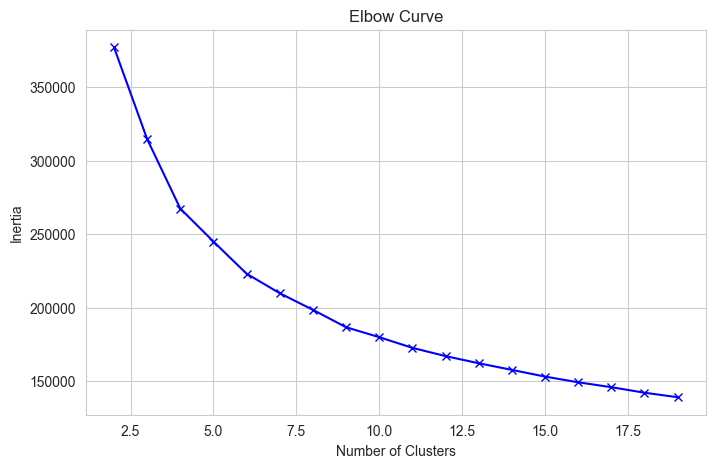

In [267]:
# Definimos un rango de 1 a 12 posibles valores de k
k_values = range(2, 20)
inertias = []

if True:
    # Entrenamos KMeans para cada valor y obtenemos la suma de los errores cuadráticos dentro de los clústeres (cohesión interna)
    for i in k_values:
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8,5))
    plt.plot(k_values, inertias, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve')
    plt.show()

Los resultados anteriores muestran que el codo comienza a estabilizarse en torno a $k = 8$. No obstante, resulta interesante observar cómo K-Means interpreta la estructura de los datos para distintos valores cercanos a ese punto, concretamente $k = 6$, $k = 7$, $k = 8$ y $k = 9$. 

Con el fin de no basar la elección del número de clústeres en una única métrica, se propone evaluar el valor óptimo de $k$ mediante el criterio de la silueta.

**Nota**: Debido a que el dataset cuenta con un número elevado de observaciones, se hace imprescindible indicar al método silhouette_score que tome una muestra aleatoria de 10.000 observaciones para que sea viable computacionalmente.


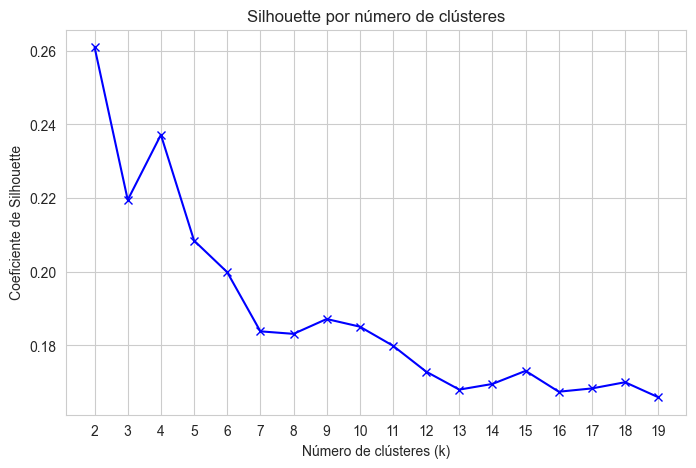

Mejor k (según Silhouette): 2


In [268]:
silhouette_scores = []
k_values = range(2, 20)

if True:
    for i in k_values:
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels, random_state = 42, sample_size=10000)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, silhouette_scores, 'bx-')
    plt.xlabel('Número de clústeres (k)')
    plt.ylabel('Coeficiente de Silhouette')
    plt.title('Silhouette por número de clústeres')
    plt.xticks(k_values)

    plt.show()

    mejor_k = k_values[np.argmax(silhouette_scores)]
    print(f'Mejor k (según Silhouette): {mejor_k}')

Como se menciona en el apartado "3.3 Generación de un diseño de comprobación", los valores de la silueta pueden fluctuar dentro de un rango comprendido en [-1, 1], siendo los valores cercanos a -1 indicativo de poca homogeneidad en los grupos y, por el contrario, valores cercanos a 1 grupos muy homogéneos. El coeficiente de la silueta indica que el valor óptimo o más representativo es $k=2$, sin embargo, este número de grupos es demasiado genérico y no ayuda a descubrir similitudes entre diferentes géneros.

Otra manera de observar el gráfico es visualizar donde la curva se estabiliza, se observa que a partir de k=12 la pérdida de homogeneidad es relativamente pequeña tomando valores cercanos al 0.17. Este hecho permite alinear el estudio con los datos obtenidos en el gráfico del método del codo, lo que refuerza tomar valores $k=7$, $k=8$ y $k=9$ e incluso probar con $k=10$.

#### 3.4.1.2 Clasificación K-Means para $k=7$

Llegados a este punto se procede a visualizar como genera las distintas agrupaciones el algoritmo k-means para un valor $k=7$. 


In [269]:
df_features_k7, k7_labels = generate_clusters_kmeans(7, X)

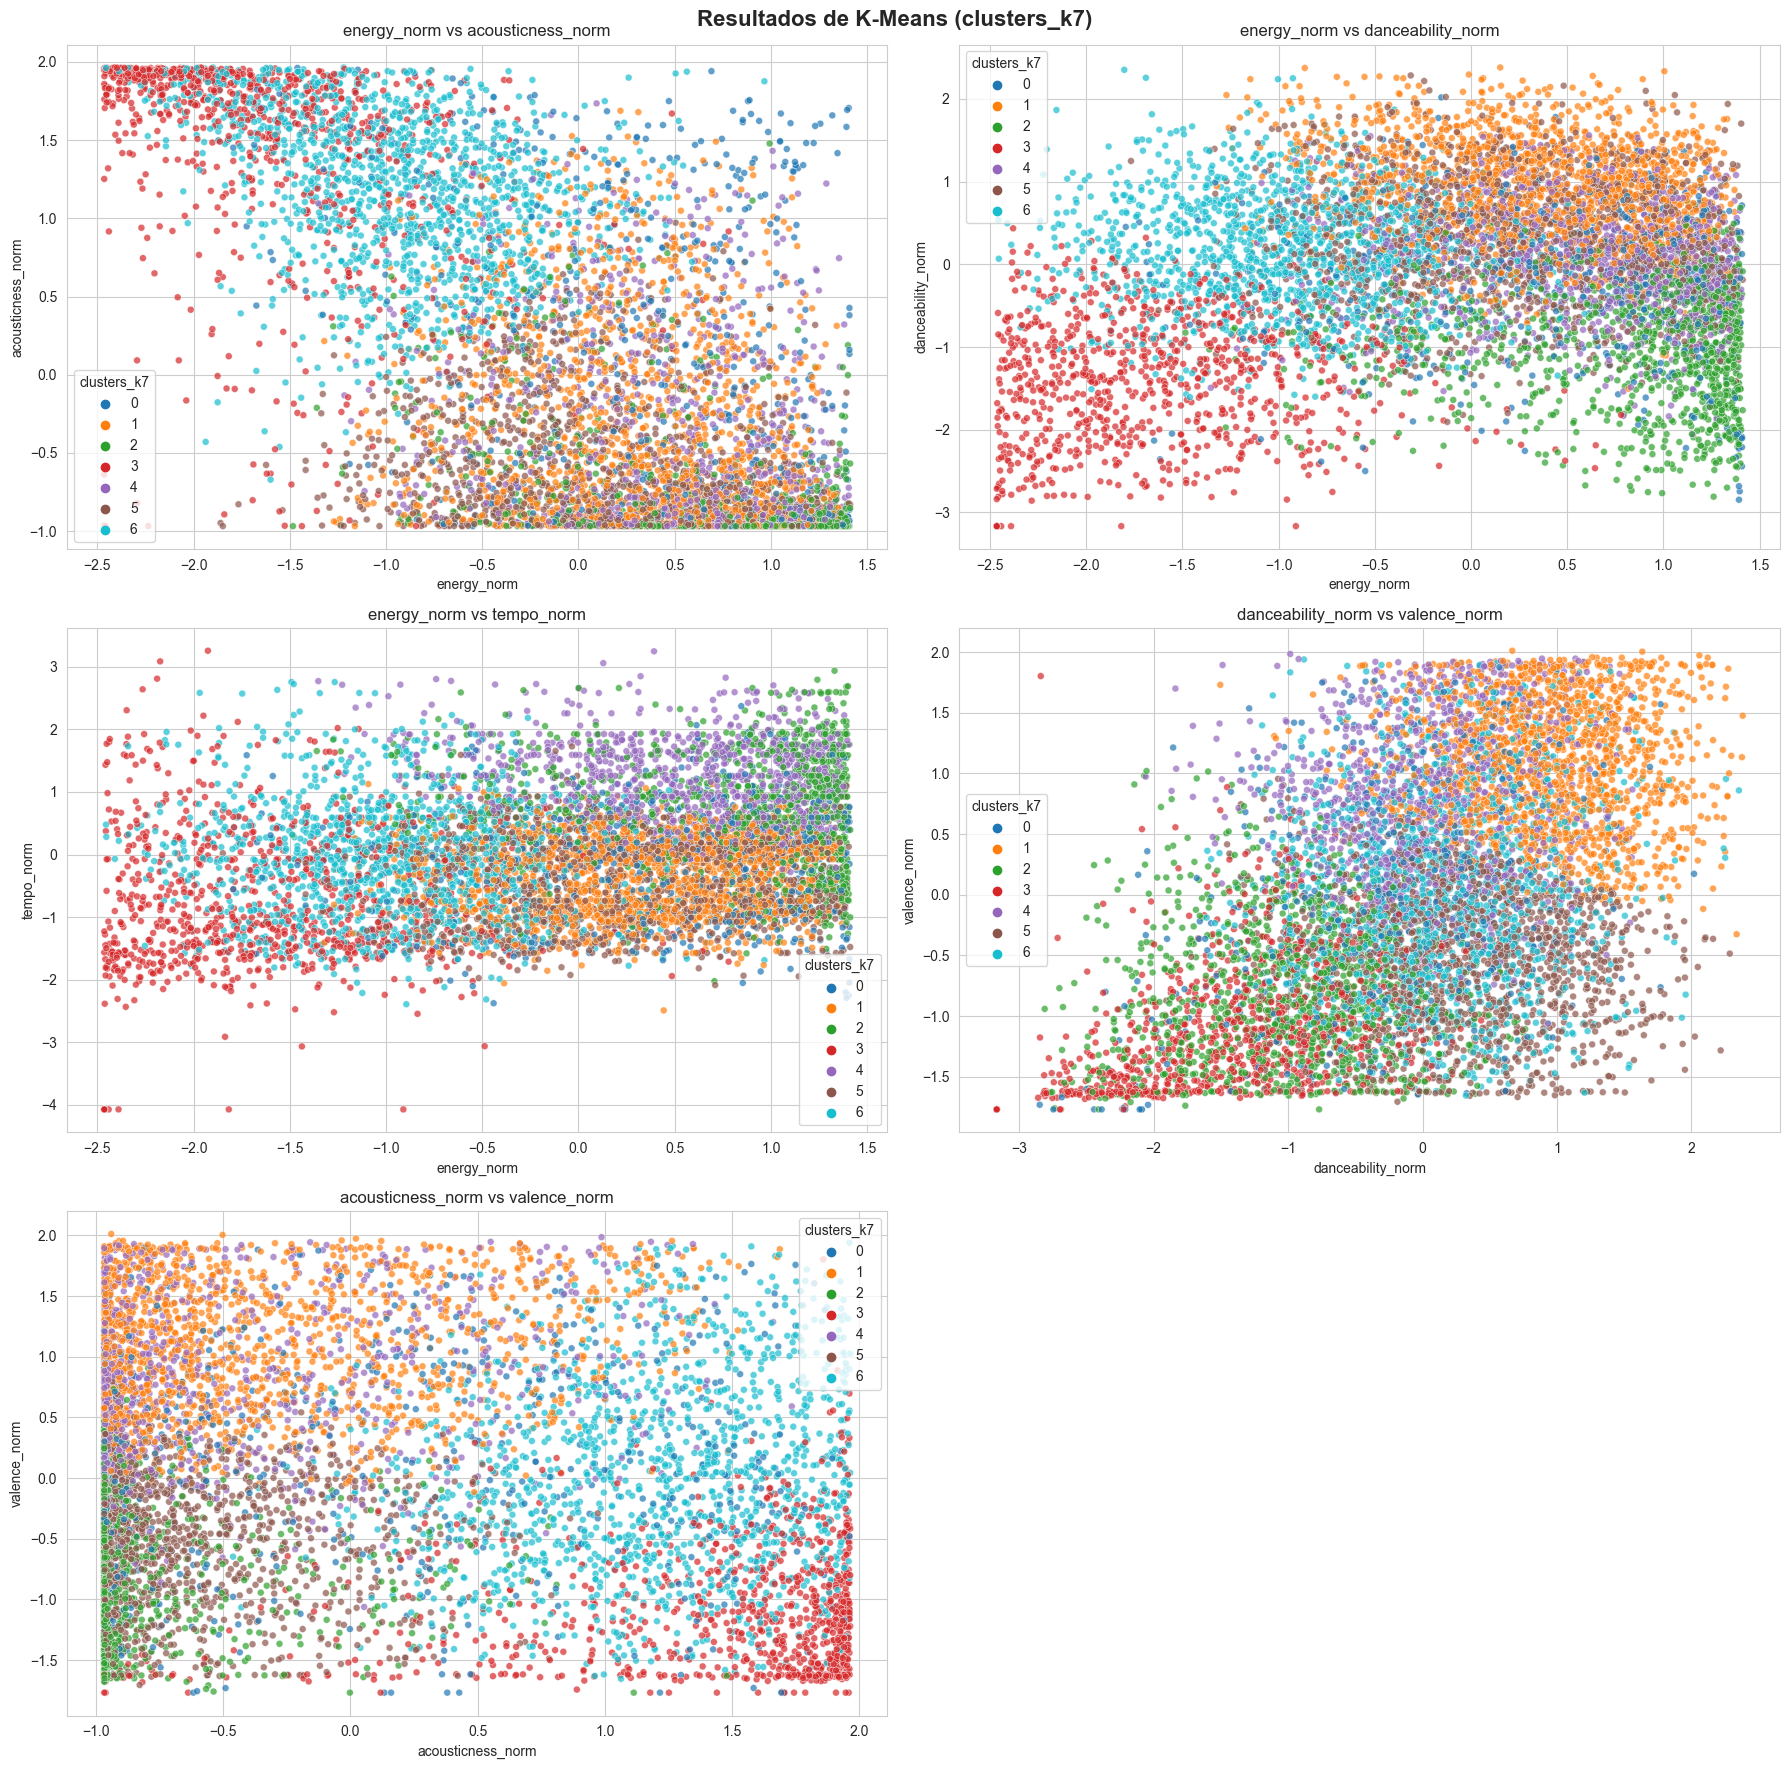

In [270]:
pair_plots = [
    ('energy_norm', 'acousticness_norm'),
    ('energy_norm', 'danceability_norm'),
    ('energy_norm', 'tempo_norm'),
    ('danceability_norm', 'valence_norm'),
    ('acousticness_norm', 'valence_norm')]

plot_clusters_kmeans(df_features_k7, k7_labels, pair_plots)

A nivel general se observa que existe cierta segmentación entre algunos grupos en los que están involucradas las variables *energy* y *acousticness* o *energy y *danceability*. Sin embargo, se puede apreciar que los límites entre clústeres no están claramente definidos ya que existen solapamientos importantes que dificulta que el algoritmo k-means pueda generar grupos representativos. 

**energy_norm vs acousticness_norm**

- Hay una clara relación inversa: a mayor energy, menor acousticness. Esto ya se observó en el análisis exploratorio de los datos.
- El cluster rojo (3) se concentra en valores altos de acousticness y bajos de energy lo que podría traducise en *trakcs* acústicos y suaves.
- El grupo verde (2) representa al conjunto de datos con más energía y menor sonoridad lo que podría corresponder a pistas de producción electrónica, heavy metal, etc.
- Se observa también que el grupo cian (6) toma valores de energía algo superior al rojo y que la ventana de sonoridad se amplía respecto a este.
- Existe un nivel de solapamiento de datos importante.

**energy_norm vs danceability_norm**

- Se observa 5 clústeres bien diferenciados que están representados en color rojo (3), cian(6), naranja (1), verde (2).
- El clúster rojo representa a los *tracks* con energía baja y baja bailabilidad propio de la música clásica, la ópera o canciones para dormir.
- El clúster cian (6) toma valores más altos de energía y bailabilidad, de hecho aquí se observa que conforme crece la energía la bailabildad aumenta.
- El clúster naranja presenta fuerte solapamiento con el clúster morado (4) y marrón (5). En esta sección se ubican los *tracks* con mayor energía y bailabidad. Cabe señalar que el grupo naranja corresponden a *tracks* muy bailables y muy enérgicos. Esta evidencia podría corresponder a géneros con perfiles electrónicos.
- El clúster verde toma fuertes valores de energía y una bailabilidad con tendencia a la baja.
- Nuevamente se observa un fuerte solapamiento de datos.

**energy_norm vs tempo_norm**

- El patrón es menos marcado ya que los clústeres se dispersan sin una frontera evidente.
- Canciones con mucha energía tienden a tempos más rápidos, pero la mayoría de colores conviven en la franja central.
- El solapamiento refuerza la idea de que K-Means no consigue aislar segmentos bien definidos.

**danceability_norm vs valence_norm**
 - Correlación positiva evidente ya estudiada en la fase de análisis de datos.
 - El clúster rojo (3) se sitúa en la zona inferior izquierda lo que indica que los *tracks* son una positividad emocional baja son muy poco bailables. 
 - Por el contrario, los clústeres azul (0) y naranja (1) dominan la esquina superior derecha representando géneros más alegres y con mayor bailabidad como el house, el techno y la música disco.
 - El resto de clústeres se reparten por la diagonal mostrando de nuevo fronteras solapadas.

**acousticness_norm vs valence_norm**
 - Este gráfico es interesante ya que su distribución toma valores con una orientación vertical a diferencia del resto. 
 - La separación de clústeres es algo mejor en comparación con el resto de variables, sin embargo, sigue habiendo solapamiento.
 - El clúster rojo (3) domina la zona de alta acousticness (≥ 1 aproximadamente) y valence baja o media Este grupo representa canciones muy acústicas y menos alegres.
 - A la izquierda con grado de sonoridad bajo aparecen mezclados azul (0), naranja (1), morado (4) y cian (6), señalando pistas menos acústicas pero con valence repartido desde valores negativos hasta positivos.
- El clúster verde (2) se concentra en el cuadrante inferior izquierdo con una acousticness baja y valence negativa. Esto indica *tracks* poco acústicas y de tono más sombrío.
- El clúster marrón (5) se distribuye en acousticness media-baja y valence negativa o cercana a cero.




**Evaluación general del modelo**

Con este contexto en mano, se procede a visualizar qué géneros a agrupado k-means por cada clúster generado:

In [271]:
# Unimos el dataframe original con las etiquetas generadas por K-Means (k=7)
df_clusters = df.copy()
df_clusters[k7_labels] = df_features_k7[k7_labels]

# Para cada clúster obtenemos el top-10 de géneros según su porcentaje de representación
cluster_summary = []
cluster_ids = sorted(df_clusters[k7_labels].unique())
for cluster_id in cluster_ids:
    cluster_tracks = df_clusters[df_clusters[k7_labels] == cluster_id]
    top_10_genres = cluster_tracks['track_genre'].value_counts(normalize=True).head(10)
    genre_text = ', '.join(f"{genre} ({percent:.1%})" for genre, percent in top_10_genres.items())
    cluster_summary.append({k7_labels: cluster_id, 'top_genres': genre_text})

# Mostramos la tabla resumen ampliando temporalmente el ancho de las columnas
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame(cluster_summary)
results.sort_values(by=k7_labels, inplace=True)

# Ocultamos el índice para evitar etiquetas duplicadas en la visualización
summary_table = results.style.hide(axis='index')
display(summary_table)

pd.reset_option('display.max_colwidth')

Después de analizar exhaustivamente los resultados sobre las agrupaciones generadas por k-means se puede observar los 10 géneros más representativos por cada clúster generado. En este punto queda **justificado que k-means consigue agrupar diversos géneros musicales muy distintos pero que comparten características musicales.** A pesar de haber obtenido buenos resultados, el modelo de recomendación podría presentar **algunas limitaciones y errores** debido a la superposición de los datos que se ha evidenciado anteriormente.  A continuación, se obtiene el rendimiento del modelo bajo los criterios seleccionados en el apartado 3.3. 

In [272]:
metricas_k7 = compute_cluster_metrics(X, df_k7_features[k7_label_col])
pd.DataFrame([metricas_k7])

Silhouette  Davies_Bouldin  Calinski_Harabasz
0        0.18            1.45           19274.82

Los valores obtenidos (Silhouette = 0.18, Davies-Bouldin = 1.45, Calinski-Harabasz ~ 19275) evidencian que el modelo K-Means para $k=7$ logra una partición moderadamente coherente donde los grupos existen y capturan cierta estructura, pero no están completamente separados. Con un índice de silueta cercano al 0.18 se demuestra que la separación entre los clústeres es casi nula lo que da lugar al solapamiento que se ha podido observar en los *scatter plots* de k-means para $k=7$. Los valores DB y CH se compararán con el resto de algoritmos con el fin de determinar cuál ofrece un mejor rendimiento para lograr el objetivo de este proyecto.

En definitiva, se ha demostrado que el algoritmo k-means ha conseguido generar clústeres en el que los *tracks* toman características parecidas. No obstante, el elevado grado de solapamiento entre grupos sugiere que la información relevante podría estar distribuida en un espacio de alta dimensionalidad. Por este motivo, se propone incorporar una técnica de reducción de dimensionalidad mediante PCA para identificar los componentes que concentran mayor varianza y volver a evaluar el modelo sobre ese espacio comprimido. El objetivo es comprobar si la separación entre clústeres mejora (índice de Silhouette más alto, Davies–Bouldin más bajo y Calinski–Harabasz más alto) y, en consecuencia, si las recomndaciones ganan interpretabilidad y precisión.

#### 3.4.1.3 Análisis de Componentes Principales (PCA)

TODO EXPLICACION

VarPerc  CumVarPerc
0  34.329089   34.329089
1  22.774616   57.103706
2  16.831129   73.934834
3  14.298449   88.233283
4   8.084900   96.318183

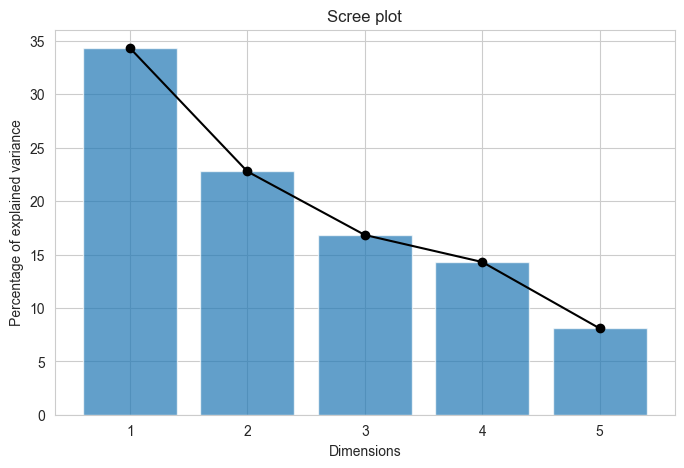

In [ ]:

# Ajuste de PCA para conservar un 95% de la varianza
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
# X_pca contiene las proyecciones de cada track en el espacio de PCs
X_pca = pca.fit_transform(X)

# Construimos la tabla con la varianza explicada individual de cada componente y la acumulada
explained_variance = pca.explained_variance_ratio_
exp_var_df = pd.DataFrame(explained_variance * 100, columns=["VarPerc"])
cum_var_df = pd.DataFrame(np.cumsum(explained_variance) * 100, columns=["CumVarPerc"])
variance_table = pd.concat([exp_var_df, cum_var_df], axis=1).rename(index={i: f"PC{i+1}" for i in range(pca.n_components_)})

display(variance_table)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, 'o-', color='black')
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7)
plt.title('Scree plot')
plt.xlabel('Dimensions')
plt.ylabel('Percentage of explained variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

En la tabla anterior se muestra, por un lado, la proporción de varianza que representa cada componente sobre el conjunto de datos y, por otro lado, la varianza acumulada total. El primer componente obtiene la mayor representación en términos de varianza sobre el conjunto de datos con un total del 34.32%. Asimismo, el segundo componente y el tercer componente toman valores de 22.77 y 16.83 respectivamente. **Como el objetivo es mantener el 95% de los datos para no perder interpretabilidad de resultados, se deberán utilizar los 5 componentes para entrenar el modelo k-means**.

Antes de proceder con ello, se procede a extraer el cos2 (*squared cosine* o calidad de representación) para comprobar qué proporción de la varianza de cada variable queda reflejada en los componentes de PCA.

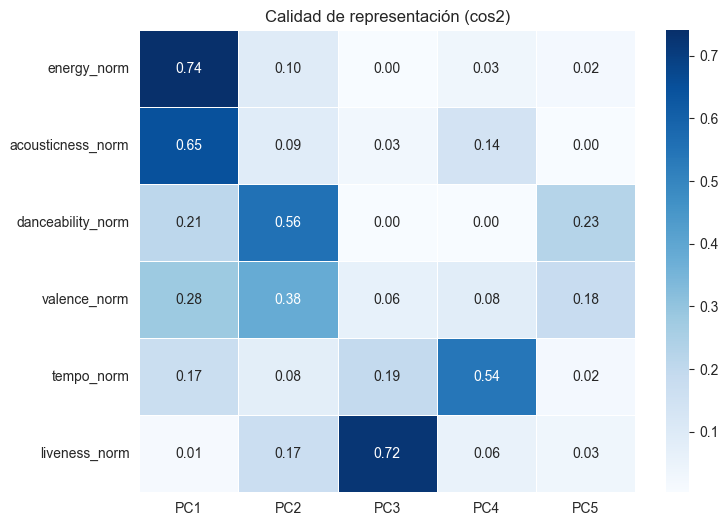

In [315]:
#Obtenemos las coordenadas de las variables 
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

# Para extraer cos2 simplemente calculamos el cuadrado de loadings
cos2 = loadings**2

plt.figure(figsize=(8, 6))
sns.heatmap(cos2, cmap="Blues", linewidths=0.4, annot=True, fmt=".2f")
plt.title("Calidad de representación (cos2)")
plt.show()

La calidad de representación ... TODO AQUIIIIIIIIIIIIIIIIII

#### 3.4.1.4 Clasificación K-means mediante componentes principales para $k=7$

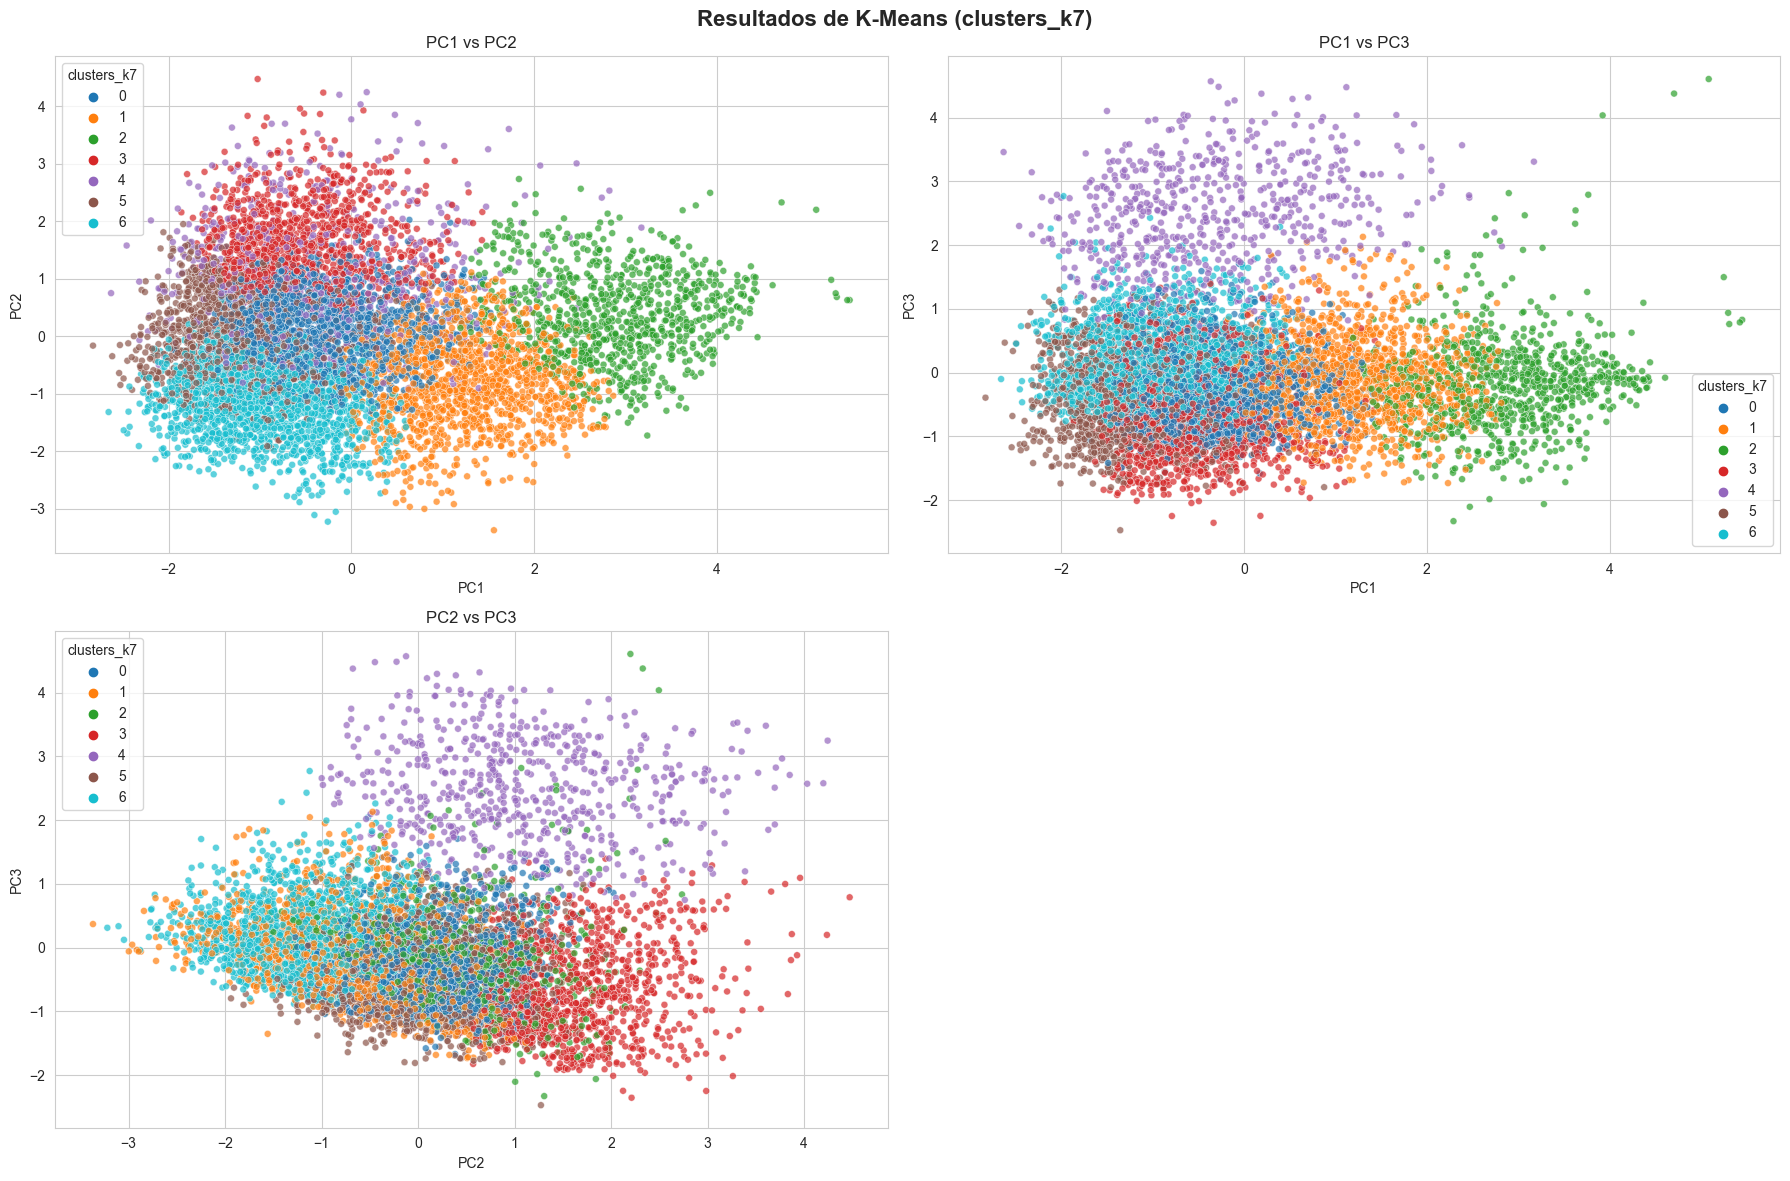

In [316]:
# Aplicamos K-Means en el espacio PCA y evaluamos el modelo
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], index=df.index)
df_k7_pca_features, k7_pca_label_col = generate_clusters_kmeans(7, df_pca)

metrics_k7_pca = compute_cluster_metrics(df_pca, df_k7_pca_features[k7_pca_label_col])
pd.DataFrame([metrics_k7_pca])

pairs = [('PC1','PC2'),('PC1', 'PC3'), ('PC2', 'PC3')]
plot_clusters_kmeans(df_k7_pca_features, k7_pca_label_col, pairs)

